In [ ]:
!pip install torch torchvision matplotlib numpy


Using device: cuda
Loading MNIST dataset...
Dataset loaded.
Running Experiment 1/1 with s = -1.00

Total experiment time: 360.84 seconds.


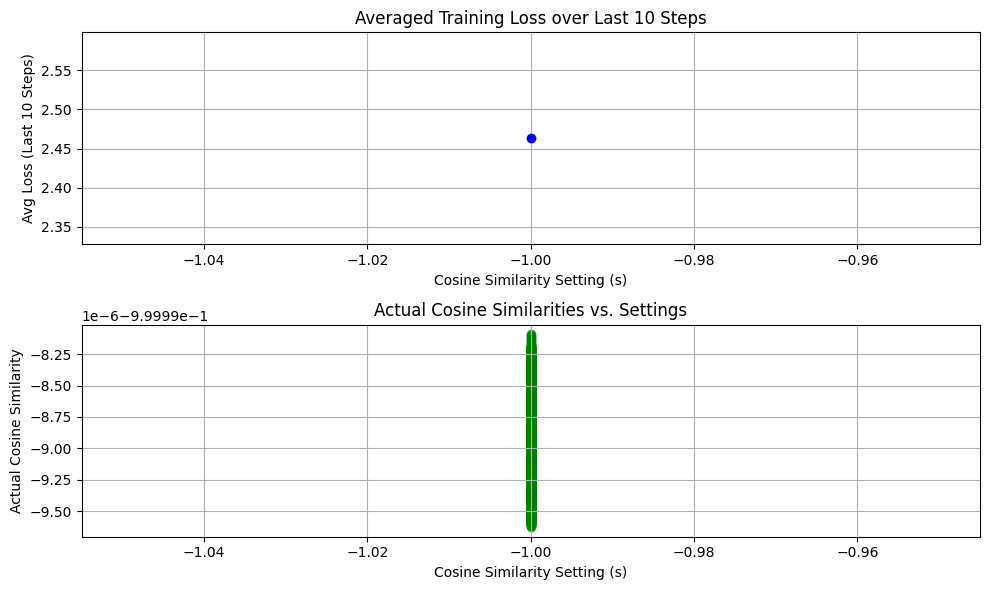

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with one hidden layer.
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# 3. Training Function
# ===========================

def train_model(cosine_similarity_setting, train_loader, step_limit=999999):
    """
    Trains the model with two optimizers, adjusting the second optimizer's gradients
    to achieve a specified cosine similarity with the first optimizer's gradients.
    
    Args:
        cosine_similarity_setting (float): Desired cosine similarity between gradients (-1 to 1).
        train_loader (DataLoader): DataLoader for the training dataset.
        step_limit (int): Number of training steps to perform.
        
    Returns:
        settings (list): List of cosine similarity settings used.
        cosine_similarities (list): List of actual cosine similarities achieved.
        avg_loss_last_10 (float): Averaged training loss over the last 10 steps.
    """
    model = SimpleNet().to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Define two optimizers with the same parameters
    optimizer1 = optim.SGD(model.parameters(), lr=0.01)
    optimizer2 = optim.SGD(model.parameters(), lr=0.01)
    
    cosine_similarities = []
    settings = []
    losses = []  # Track the training losses
    
    grads1 = None  # Initialize grads1 outside the loop
    
    # Training loop
    for epoch in range(50):  # For demonstration, we'll use 1 epoch
        for step, (inputs, labels) in enumerate(train_loader):
            # Limit the number of steps for quicker testing
            if step >= step_limit:
                break
            
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients before forward pass
            model.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track the loss
            losses.append(loss.item())
            
            # Backward pass
            loss.backward()
            
            # Alternate between optimizers per step
            if step % 2 == 0:
                # Optimizer 1
                # Save the gradients before stepping
                grads1 = []
                for param in model.parameters():
                    if param.grad is not None:
                        grads1.append(param.grad.detach().clone())
                
                optimizer1.step()
                optimizer1.zero_grad()
            else:
                # Optimizer 2
                if grads1 is None:
                    # Skip this step if grads1 is not yet available
                    optimizer2.zero_grad()
                    continue
                
                # Adjust the gradient
                grads2 = []
                idx = 0  # Index to access grads1
                for param in model.parameters():
                    if param.grad is not None:
                        g1 = grads1[idx].to(device)  # Gradient from optimizer1
                        idx += 1
                        g2 = param.grad.detach().clone().to(device)  # Current gradient from optimizer2
                        
                        # Flatten the gradients
                        g1_flat = g1.view(-1)
                        g2_flat = g2.view(-1)
                        
                        # Normalize g1
                        g1_norm = g1_flat / (g1_flat.norm() + 1e-8)  # Add epsilon to avoid division by zero
                        
                        # Decompose g2 into parallel and perpendicular components
                        g2_parallel = torch.dot(g2_flat, g1_norm) * g1_norm
                        g2_perp = g2_flat - g2_parallel
                        
                        # Normalize g2_perp
                        if g2_perp.norm() > 1e-8:
                            g2_perp_norm = g2_perp / g2_perp.norm()
                        else:
                            # Introduce a small random orthogonal vector
                            rand_vec = torch.randn_like(g2_perp).to(device)
                            rand_vec -= torch.dot(rand_vec, g1_norm) * g1_norm
                            if rand_vec.norm() > 1e-8:
                                g2_perp_norm = rand_vec / rand_vec.norm()
                            else:
                                # If still zero, set to zero vector
                                g2_perp_norm = torch.zeros_like(g2_perp)
                        
                        # Compute alpha and beta
                        g2_norm = g2_flat.norm()
                        s = float(cosine_similarity_setting)
                        val = 1.0 - s ** 2
                        val = max(val, 0.0)  # Ensure non-negative
                        beta = g2_norm * torch.sqrt(torch.clamp(torch.tensor(val, device=device), min=0.0))
                        alpha = s * g2_norm
                        
                        # Construct adjusted gradient
                        g2_prime = alpha * g1_norm + beta * g2_perp_norm
                        g2_prime = g2_prime.view_as(param.grad)
                        
                        # Replace the gradient
                        param.grad = g2_prime
                        
                        grads2.append(param.grad.detach().clone())
                
                optimizer2.step()
                optimizer2.zero_grad()
                
                # Compute cosine similarity between grads1 and grads2
                cos_sims = []
                for g1_param, g2_param in zip(grads1, grads2):
                    g1_flat = g1_param.view(-1)
                    g2_flat = g2_param.view(-1)
                    # To ensure numerical stability, add epsilon
                    denom = (g1_flat.norm() * g2_flat.norm()) + 1e-8
                    if denom > 0:
                        cos_sim = torch.dot(g1_flat, g2_flat) / denom
                        cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
                    else:
                        cos_sim = torch.tensor(0.0, device=device)
                    cos_sims.append(cos_sim.item())
                avg_cos_sim = np.mean(cos_sims)
                cosine_similarities.append(avg_cos_sim)
                settings.append(cosine_similarity_setting)
    
    # Average loss over the last 10 steps
    avg_loss_last_10 = np.mean(losses[-10:]) if len(losses) >= 10 else np.mean(losses)
    
    return settings, cosine_similarities, avg_loss_last_10

# ===========================
# 4. Experiment Runner
# ===========================

def run_experiment():
    """
    Runs the experiment across a range of cosine similarity settings.
    
    Returns:
        all_settings (list): All cosine similarity settings used.
        all_cosine_similarities (list): All actual cosine similarities achieved.
        avg_losses (list): List of averaged training loss over the last 10 steps for each setting.
    """
    # Define transformation
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Download and load the training dataset
    print("Loading MNIST dataset...")
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
    # Create a DataLoader without shuffling
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    print("Dataset loaded.")
    
    # Range of cosine similarity settings
    cosine_settings = np.linspace(-1., -1, 1)  # From -1 to 1 in steps of 0.1
    
    all_settings = []
    all_cosine_similarities = []
    avg_losses = []
    
    total_settings = len(cosine_settings)
    for idx, s in enumerate(cosine_settings, 1):
        print(f"Running Experiment {idx}/{total_settings} with s = {s:.2f}")
        settings, cosine_similarities, avg_loss_last_10 = train_model(s, train_loader)
        all_settings.extend(settings)
        all_cosine_similarities.extend(cosine_similarities)
        avg_losses.append(avg_loss_last_10)
    
    return all_settings, all_cosine_similarities, avg_losses

# ===========================
# 5. Results Visualization
# ===========================

def plot_results(all_settings, all_cosine_similarities, avg_losses):
    """
    Plots the actual cosine similarities achieved and averaged training losses.
    
    Args:
        all_settings (list): List of cosine similarity settings used.
        all_cosine_similarities (list): List of actual cosine similarities achieved.
        avg_losses (list): List of averaged training losses over the last 10 steps for each setting.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot averaged training loss over the final 10 steps
    plt.subplot(2, 1, 1)
    plt.plot(np.unique(all_settings), avg_losses, marker='o', color='blue')
    plt.title('Averaged Training Loss over Last 10 Steps')
    plt.xlabel('Cosine Similarity Setting (s)')
    plt.ylabel('Avg Loss (Last 10 Steps)')
    plt.grid(True)
    
    # Plot cosine similarities vs settings
    plt.subplot(2, 1, 2)
    plt.scatter(all_settings, all_cosine_similarities, alpha=0.7, color='green')
    plt.title('Actual Cosine Similarities vs. Settings')
    plt.xlabel('Cosine Similarity Setting (s)')
    plt.ylabel('Actual Cosine Similarity')
    plt.grid(True)
    
    # Show plots
    plt.tight_layout()
    plt.show()

# ===========================
# 6. Main Execution
# ===========================

if __name__ == "__main__":
    start_total = time.time()
    all_settings, all_cosine_similarities, avg_losses = run_experiment()
    end_total = time.time()
    print(f"\nTotal experiment time: {end_total - start_total:.2f} seconds.")
    
    # Plot the results
    plot_results(all_settings, all_cosine_similarities, avg_losses)


############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ ############ INITIAL TESTING AND UNDERSTANDING OF OPTIMIZER METHODS TO PERFORM ORTHOGONAL GRADIENT DECENT OR OTHERS ############ 

Using device: cuda

Starting Adaptive Cosine Similarity Training...
Epoch [5], Iteration [470/470], Loss: 0.1550, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 83.83 seconds.



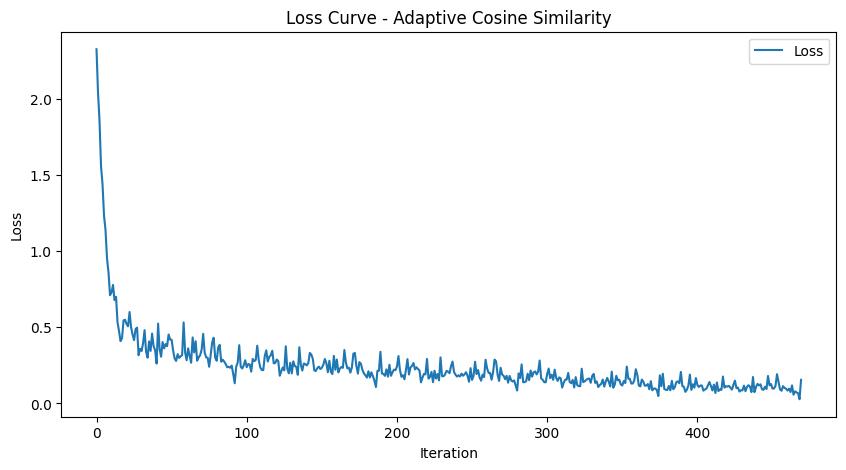

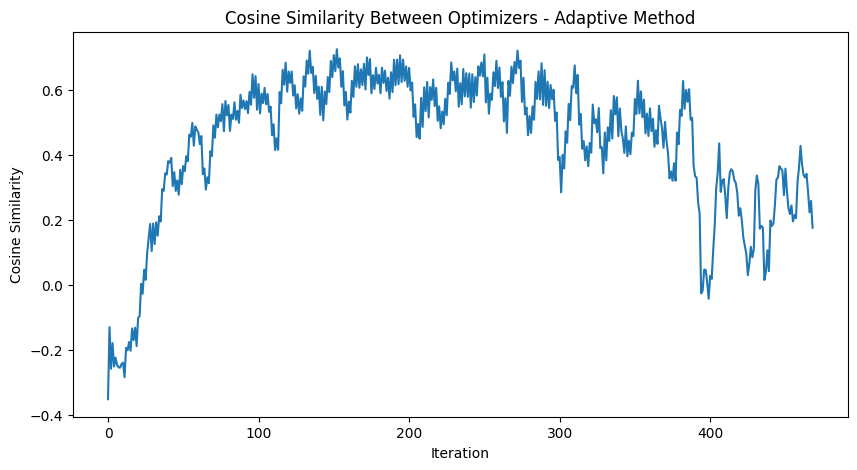

Average Loss: 0.2414
Average Cosine Similarity: 0.4399
Test Accuracy: 96.50%


In [43]:
# Part 1: Imports and Setup
# --------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Part 2: Data Preparation
# ------------------------

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)

# Create a single data loader with shuffling
batch_size = 640
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

# Load test data
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Part 3: Model Definition
# ------------------------

# Define a simple fully connected neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleNet().to(device)

# Part 4: Utility Functions
# -------------------------

# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    cos = torch.nn.functional.cosine_similarity(vec1, vec2, dim=0)
    return cos.item()

# Function to flatten model parameters or gradients into a single vector
def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to print training progress
def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], "
          f"Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Part 5: Adaptive Cosine Similarity Training Loop
# ------------------------------------------------

def train_adaptive_cosine_similarity(model, loader, epochs, desired_cos_sim=-0.6):
    print("\nStarting Adaptive Cosine Similarity Training...")
    criterion = nn.CrossEntropyLoss()
    model_adaptive = deepcopy(model).to(device)
    
    # Initialize two SGD optimizers with the same hyperparameters
    optimizer1_adaptive = optim.Adam(model_adaptive.parameters(), lr=0.001)
    optimizer2_adaptive = optim.Adam(model_adaptive.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_adaptive.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_adaptive
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_adaptive
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_adaptive(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Apply Adaptive Cosine Similarity Adjustment if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_adaptive.parameters()])
                
                # Decompose current gradients
                delta1_norm = torch.norm(last_delta1) + 1e-8
                grad_norm = torch.norm(current_grads) + 1e-8
                
                # Projection of current_grads onto delta1
                proj = (current_grads @ last_delta1) / (delta1_norm ** 2) * last_delta1
                # Orthogonal component
                orthogonal = current_grads - proj
                orthogonal_norm = torch.norm(orthogonal) + 1e-8
                
                # Compute adjusted gradients
                adjusted_grads = (desired_cos_sim * grad_norm / delta1_norm) * last_delta1 + \
                                 (np.sqrt(1 - desired_cos_sim ** 2) * grad_norm / orthogonal_norm) * orthogonal
                
                # Assign adjusted gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_adaptive.parameters():
                        num_params = p.numel()
                        p.grad.copy_(adjusted_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nAdaptive Cosine Similarity Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_adaptive, loss_list, cos_sim_list

# Part 6: Running the Adaptive Training and Analysis
# --------------------------------------------------

# Number of epochs for training
epochs = 5  # Adjust as needed

# Train the model using the adaptive cosine similarity method
desired_cos_sim = 0.  # Desired cosine similarity between -1 and 1
model_adaptive, loss_adaptive, cos_sim_adaptive = train_adaptive_cosine_similarity(
    model, train_loader, epochs=epochs, desired_cos_sim=desired_cos_sim
)

# Function to plot loss curves
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Curve - Adaptive Cosine Similarity')
    plt.legend()
    plt.show()

# Function to plot cosine similarity
def plot_cosine_similarity(cos_sims):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Optimizers - Adaptive Method')
    plt.show()

# Plot the loss and cosine similarity
plot_losses(loss_adaptive)
plot_cosine_similarity(cos_sim_adaptive)

# Compute and display average loss
avg_loss = np.mean(loss_adaptive)
print(f"Average Loss: {avg_loss:.4f}")

# Compute and display average cosine similarity
if len(cos_sim_adaptive) > 0:
    avg_cos_sim = np.mean(cos_sim_adaptive)
    print(f"Average Cosine Similarity: {avg_cos_sim:.4f}")
else:
    avg_cos_sim = None
    print(f"Average Cosine Similarity: N/A (Insufficient data)")

# Evaluate model on test data
accuracy = evaluate_model(model_adaptive, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")


Using device: cuda

Starting Baseline Training...
Epoch [5], Iteration [470/470], Loss: 0.1206, Optimizer: Optimizer2
Baseline Training Completed in 79.77 seconds.


Analysis for Baseline:


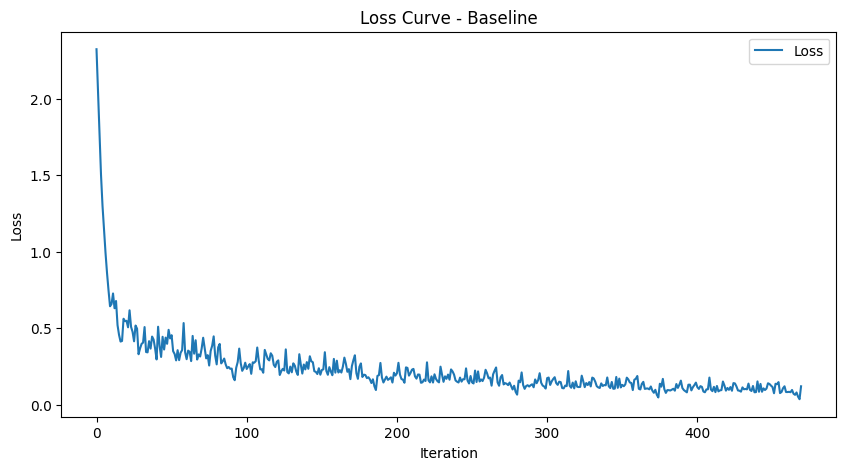

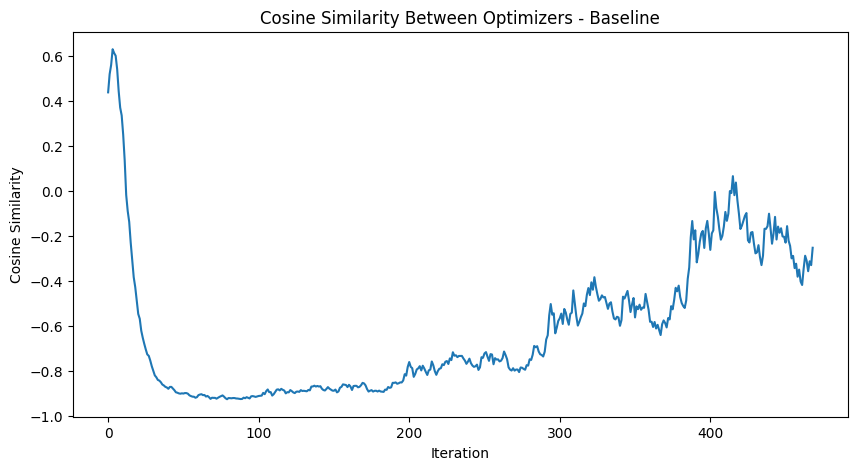

Average Loss: 0.2302
Average Cosine Similarity: -0.6205
Test Accuracy: 96.79%

Starting Orthogonal Gradient Descent Training...
Epoch [5], Iteration [470/470], Loss: 0.1634, Optimizer: Optimizer2
Orthogonal Gradient Descent Training Completed in 81.60 seconds.


Analysis for Orthogonal Gradient Descent:


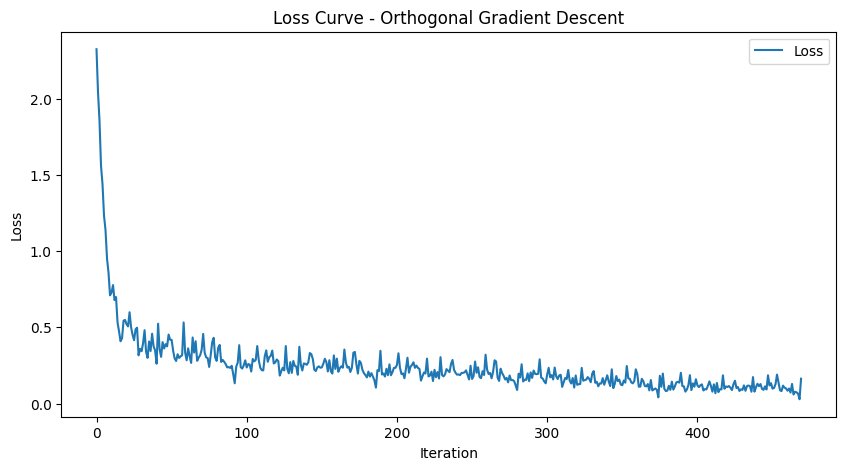

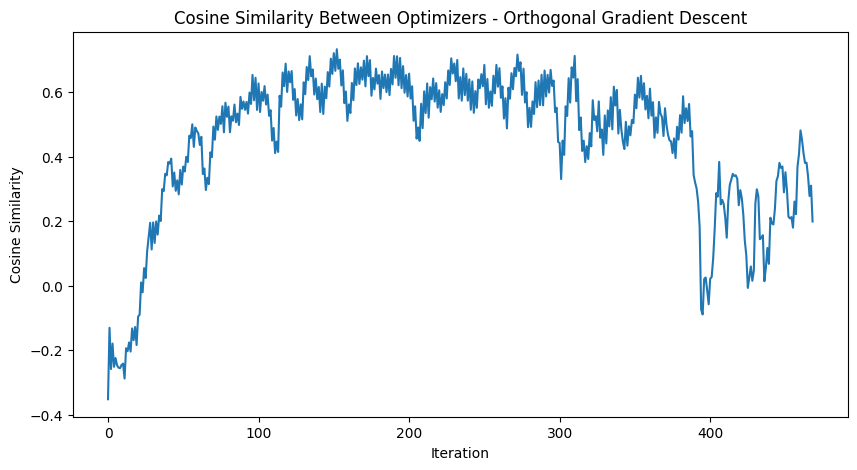

Average Loss: 0.2444
Average Cosine Similarity: 0.4505
Test Accuracy: 96.42%

Starting Repulsive Gradient Penalty Training...
Epoch [5], Iteration [470/470], Loss: 0.1330, Optimizer: Optimizer2
Repulsive Gradient Penalty Training Completed in 76.91 seconds.


Analysis for Repulsive Gradient Penalty:


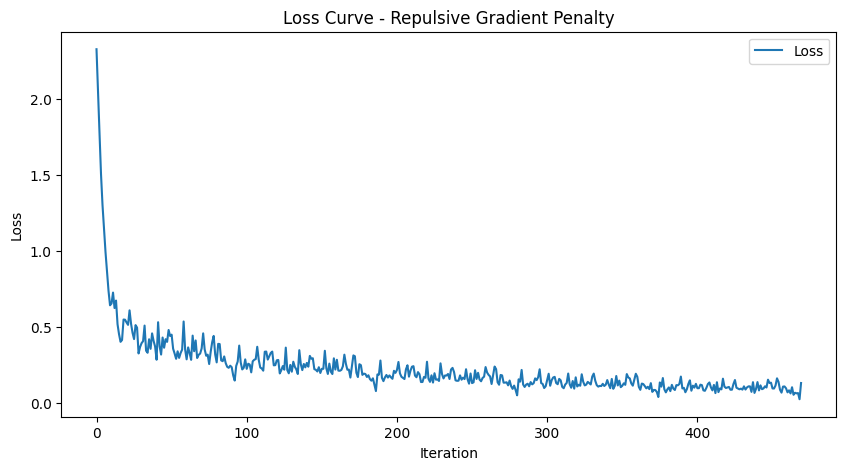

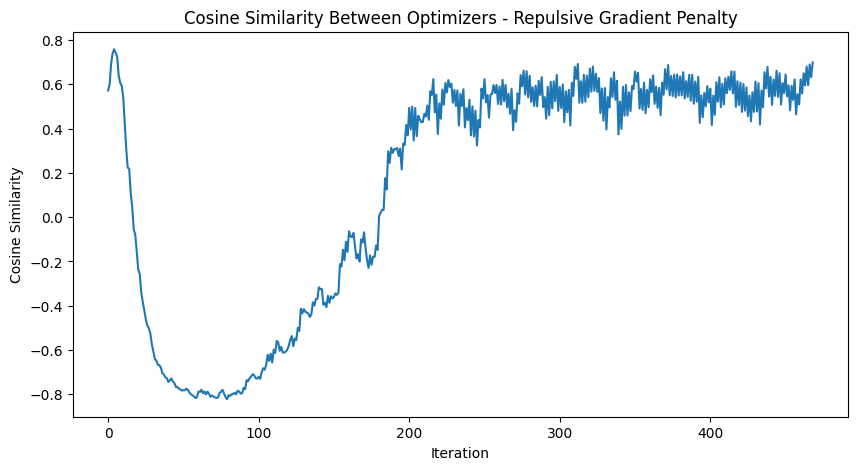

Average Loss: 0.2292
Average Cosine Similarity: 0.1526
Test Accuracy: 96.57%

Starting Cosine Similarity Penalty Training...
Epoch [5], Iteration [470/470], Loss: 0.1196, Optimizer: Optimizer2
Cosine Similarity Penalty Training Completed in 77.98 seconds.


Analysis for Cosine Similarity Penalty:


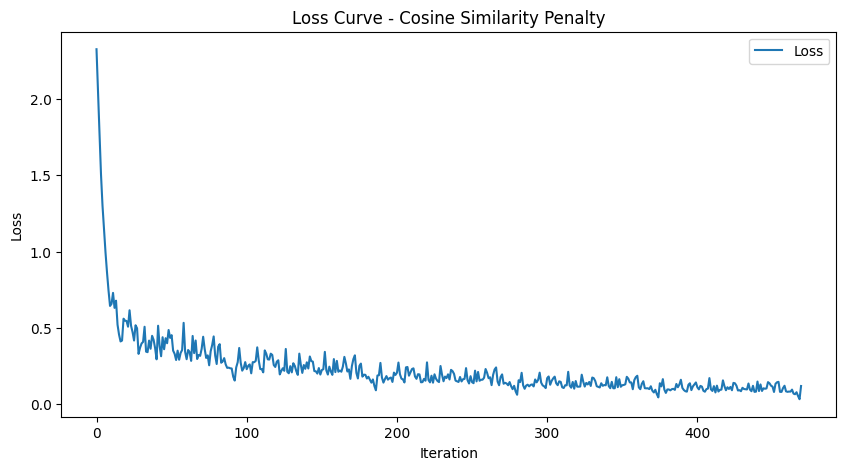

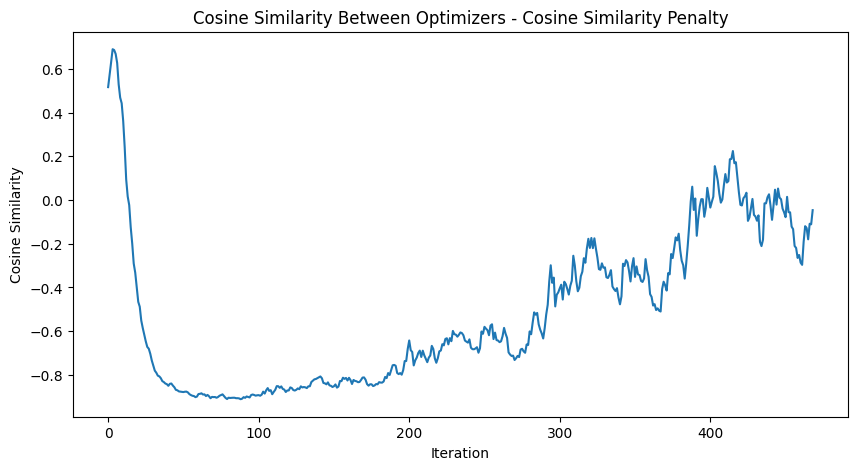

Average Loss: 0.2293
Average Cosine Similarity: -0.5141
Test Accuracy: 96.79%

Cross-Experiment Comparison:


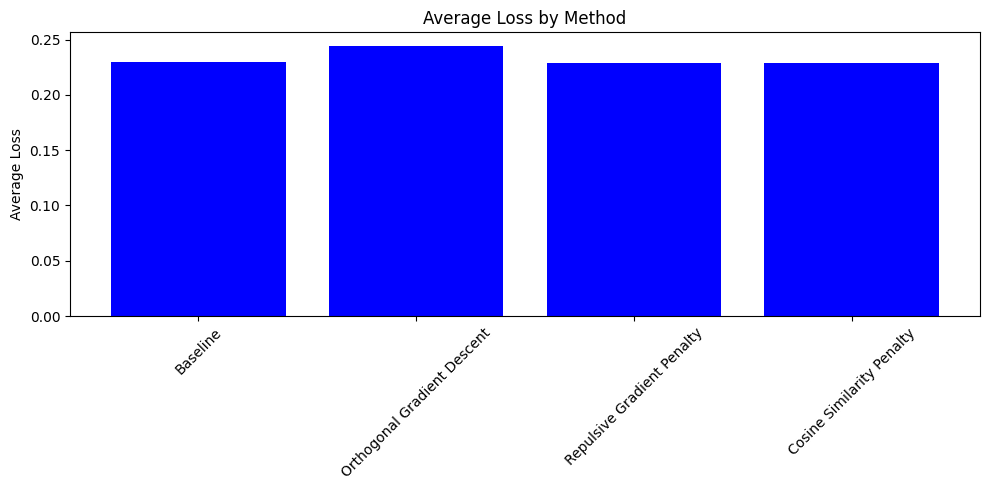

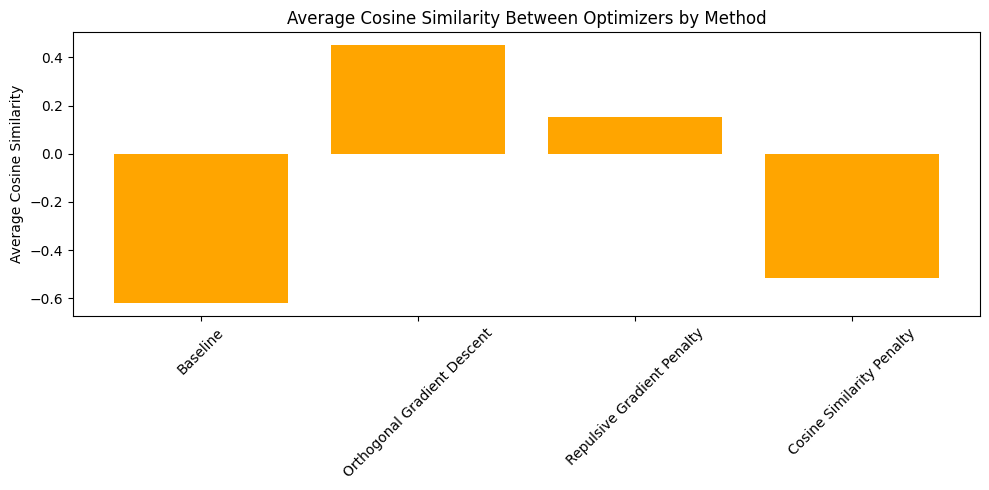

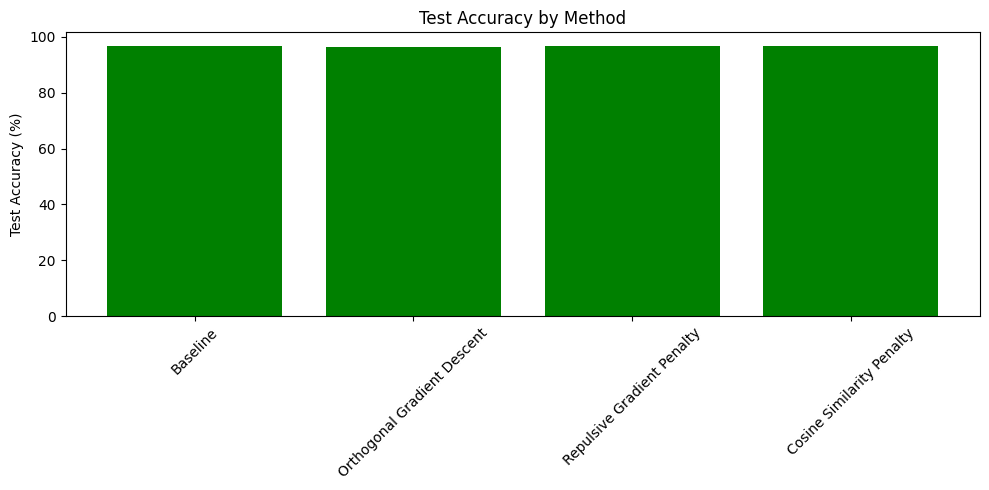


Best Method: Baseline with Test Accuracy: 96.79%

Summary of Findings:

Method: Baseline
Average Loss: 0.2302
Average Cosine Similarity: -0.6205
Test Accuracy: 96.79%

Method: Orthogonal Gradient Descent
Average Loss: 0.2444
Average Cosine Similarity: 0.4505
Test Accuracy: 96.42%

Method: Repulsive Gradient Penalty
Average Loss: 0.2292
Average Cosine Similarity: 0.1526
Test Accuracy: 96.57%

Method: Cosine Similarity Penalty
Average Loss: 0.2293
Average Cosine Similarity: -0.5141
Test Accuracy: 96.79%

Conclusion:
The method 'Baseline' achieved the highest test accuracy.
Further experimentation with hyperparameters and longer training may provide more insights.


In [11]:
# Part 1: Imports and Setup
# --------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Part 2: Data Preparation
# ------------------------

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)

# Create a single data loader with shuffling
batch_size = 640
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

# Load test data
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Part 3: Model Definition
# ------------------------

# Define a simple fully connected neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleNet().to(device)

# Part 4: Utility Functions
# -------------------------

# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    cos = torch.nn.functional.cosine_similarity(vec1, vec2, dim=0)
    return cos.item()

# Function to flatten model parameters or gradients into a single vector
def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to print training progress
def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], "
          f"Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Part 5: Training Functions with Divergence Methods
# --------------------------------------------------

# 1. Baseline Training Loop (No divergence enforcement)
def train_baseline(model, loader, epochs):
    print("\nStarting Baseline Training...")
    criterion = nn.CrossEntropyLoss()
    model_baseline = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)
    optimizer2_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_baseline.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_baseline
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_baseline
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_baseline(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_baseline.parameters()])
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_baseline.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nBaseline Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_baseline, loss_list, cos_sim_list

# 2. Orthogonal Gradient Descent (OGD) Training Loop
def train_ogd(model, loader, epochs):
    print("\nStarting Orthogonal Gradient Descent Training...")
    criterion = nn.CrossEntropyLoss()
    model_ogd = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_ogd = optim.Adam(model_ogd.parameters(), lr=0.001)
    optimizer2_ogd = optim.Adam(model_ogd.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_ogd.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_ogd
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_ogd
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_ogd(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_ogd.parameters()])
            
            # Apply Orthogonal Gradient Descent if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_ogd.parameters()])
                # Orthogonalize current gradients w.r.t last_delta1
                dot_product = torch.dot(last_delta1, current_grads)
                norm_sq = torch.norm(last_delta1) ** 2 + 1e-8
                orth_grad = current_grads - (dot_product / norm_sq) * last_delta1
                # Assign orthogonal gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_ogd.parameters():
                        num_params = p.numel()
                        p.grad.copy_(orth_grad[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_ogd.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nOrthogonal Gradient Descent Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_ogd, loss_list, cos_sim_list

# 3. Repulsive Gradient Penalty Training Loop
def train_repulsive(model, loader, epochs, lambda_penalty=0.1):
    print("\nStarting Repulsive Gradient Penalty Training...")
    criterion = nn.CrossEntropyLoss()
    model_repulsive = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_repulsive = optim.Adam(model_repulsive.parameters(), lr=0.001)
    optimizer2_repulsive = optim.Adam(model_repulsive.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_repulsive.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_repulsive
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_repulsive
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_repulsive(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_repulsive.parameters()])
            
            # Apply Repulsive Gradient Penalty if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_repulsive.parameters()])
                # Compute repulsive penalty
                repulsive_penalty = lambda_penalty * (last_delta1 / (torch.norm(last_delta1) + 1e-8))
                # Modify gradients to include repulsive penalty
                modified_grads = current_grads - repulsive_penalty
                # Assign modified gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_repulsive.parameters():
                        num_params = p.numel()
                        p.grad.copy_(modified_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_repulsive.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nRepulsive Gradient Penalty Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_repulsive, loss_list, cos_sim_list

# 4. Cosine Similarity Penalty Training Loop
def train_cosine_penalty(model, loader, epochs, lambda_penalty=0.1):
    print("\nStarting Cosine Similarity Penalty Training...")
    criterion = nn.CrossEntropyLoss()
    model_cosine = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_cosine = optim.Adam(model_cosine.parameters(), lr=0.001)
    optimizer2_cosine = optim.Adam(model_cosine.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_cosine.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_cosine
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_cosine
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_cosine(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_cosine.parameters()])
            
            # Apply Cosine Similarity Penalty if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_cosine.parameters()])
                # Compute cosine similarity
                cos_sim = cosine_similarity(last_delta1, current_grads)
                # Apply penalty
                penalty = lambda_penalty * last_delta1
                # Modify gradients to include cosine similarity penalty
                modified_grads = current_grads - penalty
                # Assign modified gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_cosine.parameters():
                        num_params = p.numel()
                        p.grad.copy_(modified_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_cosine.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nCosine Similarity Penalty Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_cosine, loss_list, cos_sim_list

# Part 6: Running Experiments and Analysis
# ----------------------------------------

# Number of epochs for training
epochs = 5  # You can increase this for better results

# List to store results from each method
experiment_results = []

# Function to plot loss curves
def plot_losses(losses, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {method_name}')
    plt.legend()
    plt.show()

# Function to plot cosine similarity
def plot_cosine_similarity(cos_sims, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title(f'Cosine Similarity Between Optimizers - {method_name}')
    plt.show()

# Function to perform analysis after each experiment
def analyze_experiment(model, losses, cos_sims, method_name):
    print(f"\nAnalysis for {method_name}:")
    # Plot loss curves
    plot_losses(losses, method_name)
    # Plot cosine similarity
    plot_cosine_similarity(cos_sims, method_name)
    # Compute and display average loss
    avg_loss = np.mean(losses)
    print(f"Average Loss: {avg_loss:.4f}")
    # Compute and display average cosine similarity
    if len(cos_sims) > 0:
        avg_cos_sim = np.mean(cos_sims)
        print(f"Average Cosine Similarity: {avg_cos_sim:.4f}")
    else:
        avg_cos_sim = None
        print(f"Average Cosine Similarity: N/A (Insufficient data)")
    # Evaluate model on test data
    accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return {
        'model': model,
        'losses': losses,
        'cos_sims': cos_sims,
        'avg_loss': avg_loss,
        'avg_cos_sim': avg_cos_sim,
        'accuracy': accuracy,
        'method': method_name
    }

# Baseline Training and Analysis
model_baseline, loss_baseline, cos_sim_baseline = train_baseline(
    model, train_loader, epochs=epochs
)
result_baseline = analyze_experiment(
    model_baseline, loss_baseline, cos_sim_baseline, "Baseline"
)
experiment_results.append(result_baseline)

# Orthogonal Gradient Descent Training and Analysis
model_ogd, loss_ogd, cos_sim_ogd = train_ogd(
    model, train_loader, epochs=epochs
)
result_ogd = analyze_experiment(
    model_ogd, loss_ogd, cos_sim_ogd, "Orthogonal Gradient Descent"
)
experiment_results.append(result_ogd)

# Repulsive Gradient Penalty Training and Analysis
model_repulsive, loss_repulsive, cos_sim_repulsive = train_repulsive(
    model, train_loader, epochs=epochs, lambda_penalty=0.1
)
result_repulsive = analyze_experiment(
    model_repulsive, loss_repulsive, cos_sim_repulsive, "Repulsive Gradient Penalty"
)
experiment_results.append(result_repulsive)

# Cosine Similarity Penalty Training and Analysis
model_cosine, loss_cosine, cos_sim_cosine = train_cosine_penalty(
    model, train_loader, epochs=epochs, lambda_penalty=0.1
)
result_cosine = analyze_experiment(
    model_cosine, loss_cosine, cos_sim_cosine, "Cosine Similarity Penalty"
)
experiment_results.append(result_cosine)

# Part 7: Cross-Experiment Comparison
# -----------------------------------

# Compare average losses
def compare_losses(results):
    methods = [res['method'] for res in results]
    avg_losses = [res['avg_loss'] for res in results]
    
    plt.figure(figsize=(10, 5))
    plt.bar(methods, avg_losses, color='blue')
    plt.ylabel('Average Loss')
    plt.title('Average Loss by Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compare average cosine similarities
def compare_cosine_similarities(results):
    methods = [res['method'] for res in results]
    avg_cos_sims = [res['avg_cos_sim'] if res['avg_cos_sim'] is not None else 0 for res in results]
    
    plt.figure(figsize=(10, 5))
    plt.bar(methods, avg_cos_sims, color='orange')
    plt.ylabel('Average Cosine Similarity')
    plt.title('Average Cosine Similarity Between Optimizers by Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compare test accuracies
def compare_accuracies(results):
    methods = [res['method'] for res in results]
    accuracies = [res['accuracy'] for res in results]
    
    plt.figure(figsize=(10, 5))
    plt.bar(methods, accuracies, color='green')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy by Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Perform comparisons
print("\nCross-Experiment Comparison:")
compare_losses(experiment_results)
compare_cosine_similarities(experiment_results)
compare_accuracies(experiment_results)

# Part 8: Conclusion
# ------------------

# Determine the best method based on test accuracy
best_result = max(experiment_results, key=lambda x: x['accuracy'])
print(f"\nBest Method: {best_result['method']} with Test Accuracy: {best_result['accuracy']:.2f}%")

# Summary of findings
print("\nSummary of Findings:")
for res in experiment_results:
    print(f"\nMethod: {res['method']}")
    print(f"Average Loss: {res['avg_loss']:.4f}")
    if res['avg_cos_sim'] is not None:
        print(f"Average Cosine Similarity: {res['avg_cos_sim']:.4f}")
    else:
        print(f"Average Cosine Similarity: N/A")
    print(f"Test Accuracy: {res['accuracy']:.2f}%")

print("\nConclusion:")
print(f"The method '{best_result['method']}' achieved the highest test accuracy.")
print("Further experimentation with hyperparameters and longer training may provide more insights.")

# End of Script


Using device: cuda

Starting Orthogonal Gradient Descent (SGD) Training...
Epoch [5], Iteration [470/470], Loss: 0.3669, Optimizer: Optimizer2
Orthogonal Gradient Descent (SGD) Training Completed in 79.28 seconds.


Starting Repulsive Gradient Penalty (SGD) Training...
Epoch [5], Iteration [470/470], Loss: 0.3249, Optimizer: Optimizer2
Repulsive Gradient Penalty (SGD) Training Completed in 78.01 seconds.



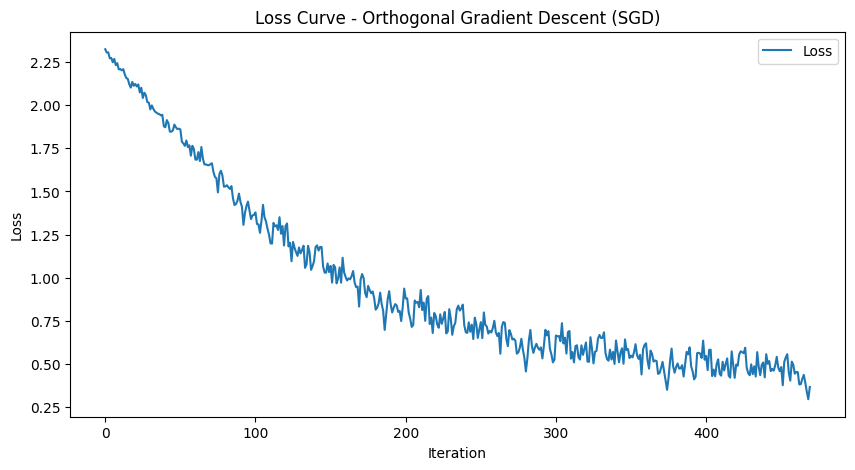

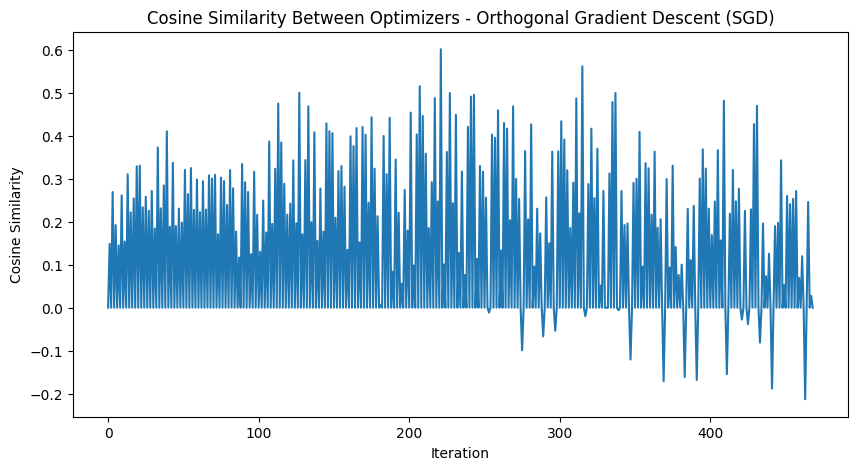

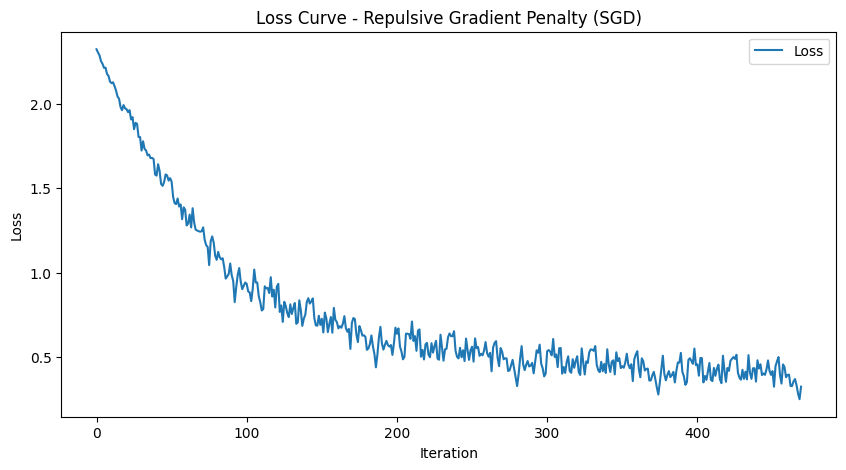

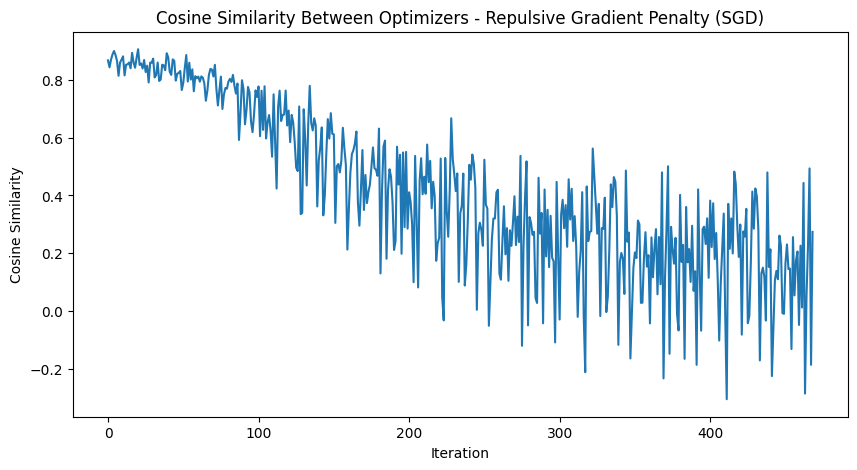

Orthogonal Gradient Descent (SGD) Test Accuracy: 88.91%
Repulsive Gradient Penalty (SGD) Test Accuracy: 89.91%


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=640, shuffle=False)

# Model Definition
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet().to(device)

# Utility Functions
def cosine_similarity(vec1, vec2):
    return torch.nn.functional.cosine_similarity(vec1, vec2, dim=0).item()

def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    return 100 * correct / total

def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# 1. Orthogonal Gradient Descent (OGD) with SGD
def train_ogd_sgd(model, loader, epochs):
    print("\nStarting Orthogonal Gradient Descent (SGD) Training...")
    criterion = nn.CrossEntropyLoss()
    model_ogd = deepcopy(model).to(device)
    
    optimizer1_ogd = optim.SGD(model_ogd.parameters(), lr=0.01)
    optimizer2_ogd = optim.SGD(model_ogd.parameters(), lr=0.01)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_ogd.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            optimizer = optimizer1_ogd if batch_idx % 2 == 0 else optimizer2_ogd
            optimizer_name = 'Optimizer1' if batch_idx % 2 == 0 else 'Optimizer2'
            
            optimizer.zero_grad()
            
            output = model_ogd(data)
            loss = criterion(output, target)
            
            loss.backward()
            
            params_before = flatten_params([p.data.clone() for p in model_ogd.parameters()])
            
            # Apply Orthogonal Gradient Descent (only for Optimizer2)
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                current_grads = flatten_params([p.grad.clone() for p in model_ogd.parameters()])
                dot_product = torch.dot(last_delta1, current_grads)
                norm_sq = torch.norm(last_delta1) ** 2 + 1e-8
                orth_grad = current_grads - (dot_product / norm_sq) * last_delta1
                
                with torch.no_grad():
                    idx = 0
                    for p in model_ogd.parameters():
                        num_params = p.numel()
                        p.grad.copy_(orth_grad[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            optimizer.step()
            
            params_after = flatten_params([p.data.clone() for p in model_ogd.parameters()])
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            loss_list.append(loss.item())
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nOrthogonal Gradient Descent (SGD) Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_ogd, loss_list, cos_sim_list

# 2. Repulsive Gradient Penalty with SGD
def train_repulsive_sgd(model, loader, epochs, lambda_penalty=0.1):
    print("\nStarting Repulsive Gradient Penalty (SGD) Training...")
    criterion = nn.CrossEntropyLoss()
    model_repulsive = deepcopy(model).to(device)
    
    optimizer1_repulsive = optim.SGD(model_repulsive.parameters(), lr=0.01)
    optimizer2_repulsive = optim.SGD(model_repulsive.parameters(), lr=0.01)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_repulsive.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            optimizer = optimizer1_repulsive if batch_idx % 2 == 0 else optimizer2_repulsive
            optimizer_name = 'Optimizer1' if batch_idx % 2 == 0 else 'Optimizer2'
            
            optimizer.zero_grad()
            
            output = model_repulsive(data)
            loss = criterion(output, target)
            
            loss.backward()
            
            params_before = flatten_params([p.data.clone() for p in model_repulsive.parameters()])
            
            # Apply Repulsive Gradient Penalty (only for Optimizer2)
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                current_grads = flatten_params([p.grad.clone() for p in model_repulsive.parameters()])
                repulsive_penalty = lambda_penalty * (last_delta1 / (torch.norm(last_delta1) + 1e-8))
                modified_grads = current_grads - repulsive_penalty
                
                with torch.no_grad():
                    idx = 0
                    for p in model_repulsive.parameters():
                        num_params = p.numel()
                        p.grad.copy_(modified_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            optimizer.step()
            
            params_after = flatten_params([p.data.clone() for p in model_repulsive.parameters()])
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            loss_list.append(loss.item())
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nRepulsive Gradient Penalty (SGD) Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_repulsive, loss_list, cos_sim_list

# Running Experiments
epochs = 5

# 1. Orthogonal Gradient Descent (SGD)
model_ogd_sgd, loss_ogd_sgd, cos_sim_ogd_sgd = train_ogd_sgd(model, train_loader, epochs)

# 2. Repulsive Gradient Penalty (SGD)
model_repulsive_sgd, loss_repulsive_sgd, cos_sim_repulsive_sgd = train_repulsive_sgd(model, train_loader, epochs)

# Visualization
def plot_losses(losses, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {method_name}')
    plt.legend()
    plt.show()

def plot_cosine_similarity(cos_sims, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title(f'Cosine Similarity Between Optimizers - {method_name}')
    plt.show()

# Plot Results for Orthogonal Gradient Descent (SGD)
plot_losses(loss_ogd_sgd, "Orthogonal Gradient Descent (SGD)")
plot_cosine_similarity(cos_sim_ogd_sgd, "Orthogonal Gradient Descent (SGD)")

# Plot Results for Repulsive Gradient Penalty (SGD)
plot_losses(loss_repulsive_sgd, "Repulsive Gradient Penalty (SGD)")
plot_cosine_similarity(cos_sim_repulsive_sgd, "Repulsive Gradient Penalty (SGD)")

# Evaluate Models
accuracy_ogd_sgd = evaluate_model(model_ogd_sgd, test_loader)
accuracy_repulsive_sgd = evaluate_model(model_repulsive_sgd, test_loader)

print(f"Orthogonal Gradient Descent (SGD) Test Accuracy: {accuracy_ogd_sgd:.2f}%")
print(f"Repulsive Gradient Penalty (SGD) Test Accuracy: {accuracy_repulsive_sgd:.2f}%")


Using device: cuda

Starting Orthogonal Gradient Descent with Distance Penalty (ADAM) Training...
Epoch [5], Iteration [470/470], Loss: 0.3484, Optimizer: Optimizer2
Orthogonal Gradient Descent with Distance Penalty (ADAM) Training Completed in 83.62 seconds.



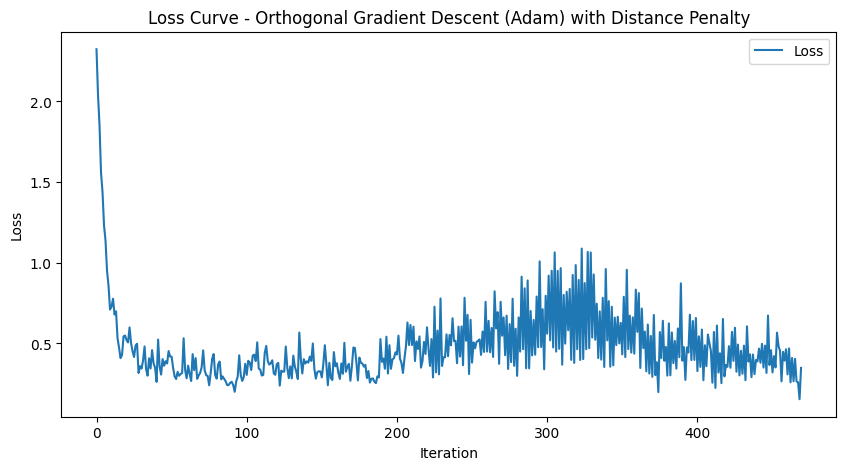

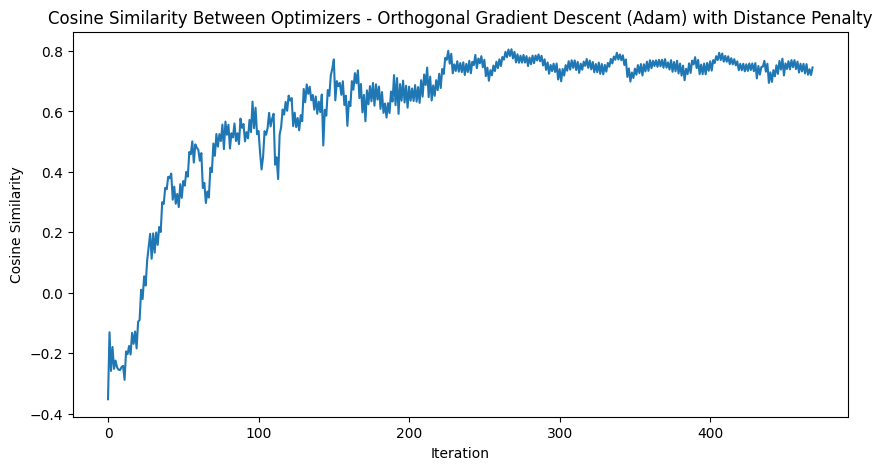

Orthogonal Gradient Descent with Distance Penalty (Adam) Test Accuracy: 91.22%


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=640, shuffle=False)

# Model Definition
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet().to(device)

# Utility Functions
def cosine_similarity(vec1, vec2):
    return torch.nn.functional.cosine_similarity(vec1, vec2, dim=0).item()

def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    return 100 * correct / total

def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Fixed Distance Penalty: Apply if distance between parameters is below threshold
def apply_distance_penalty(model, params_before, params_after, d_min=0.01, lambda_penalty=0.1):
    distance = torch.norm(flatten_params(params_before) - flatten_params(params_after))
    if distance < d_min:
        penalty = lambda_penalty * (d_min - distance)
        for p in model.parameters():
            p.data.add_(penalty)

# 1. Orthogonal Gradient Descent with Distance Penalty (SGD/Adam)
def train_ogd_with_distance_penalty(model, loader, epochs, optimizer_type='sgd', d_min=0.01, lambda_penalty=0.1):
    print(f"\nStarting Orthogonal Gradient Descent with Distance Penalty ({optimizer_type.upper()}) Training...")
    criterion = nn.CrossEntropyLoss()
    model_ogd = deepcopy(model).to(device)
    
    if optimizer_type == 'sgd':
        optimizer1 = optim.SGD(model_ogd.parameters(), lr=0.01)
        optimizer2 = optim.SGD(model_ogd.parameters(), lr=0.01)
    else:  # 'adam'
        optimizer1 = optim.Adam(model_ogd.parameters(), lr=0.001)
        optimizer2 = optim.Adam(model_ogd.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_ogd.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            optimizer = optimizer1 if batch_idx % 2 == 0 else optimizer2
            optimizer_name = 'Optimizer1' if batch_idx % 2 == 0 else 'Optimizer2'
            
            optimizer.zero_grad()
            output = model_ogd(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Before Update: Store params for distance calculation
            params_before = deepcopy([p.data.clone() for p in model_ogd.parameters()])
            
            # Orthogonal Gradient Descent for Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                current_grads = flatten_params([p.grad.clone() for p in model_ogd.parameters()])
                dot_product = torch.dot(last_delta1, current_grads)
                norm_sq = torch.norm(last_delta1) ** 2 + 1e-8
                orth_grad = current_grads - (dot_product / norm_sq) * last_delta1
                
                with torch.no_grad():
                    idx = 0
                    for p in model_ogd.parameters():
                        num_params = p.numel()
                        p.grad.copy_(orth_grad[idx:idx+num_params].view_as(p))
                        idx += num_params

            optimizer.step()

            # After Update: Calculate distance and apply penalty if too close
            params_after = deepcopy([p.data.clone() for p in model_ogd.parameters()])
            apply_distance_penalty(model_ogd, params_before, params_after, d_min, lambda_penalty)
            
            # Track Cosine Similarity and Update List
            params_after_flat = flatten_params(params_after)
            delta = params_after_flat - flatten_params(params_before)
            optimizer_updates[optimizer_name].append(delta)
            
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            loss_list.append(loss.item())
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nOrthogonal Gradient Descent with Distance Penalty ({optimizer_type.upper()}) Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_ogd, loss_list, cos_sim_list

# Running Experiments
epochs = 5
d_min = 0.1  # Minimum distance between parameter sets
lambda_penalty = 0.5  # Penalty strength

# 2. Orthogonal Gradient Descent with Distance Penalty (Adam)
model_ogd_adam, loss_ogd_adam, cos_sim_ogd_adam = train_ogd_with_distance_penalty(
    model, train_loader, epochs, optimizer_type='adam', d_min=d_min, lambda_penalty=lambda_penalty
)

# Visualization
def plot_losses(losses, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {method_name}')
    plt.legend()
    plt.show()

def plot_cosine_similarity(cos_sims, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title(f'Cosine Similarity Between Optimizers - {method_name}')
    plt.show()

# Plot Results for Orthogonal Gradient Descent with Distance Penalty (Adam)
plot_losses(loss_ogd_adam, "Orthogonal Gradient Descent (Adam) with Distance Penalty")
plot_cosine_similarity(cos_sim_ogd_adam, "Orthogonal Gradient Descent (Adam) with Distance Penalty")


accuracy_ogd_adam = evaluate_model(model_ogd_adam, test_loader)

print(f"Orthogonal Gradient Descent with Distance Penalty (Adam) Test Accuracy: {accuracy_ogd_adam:.2f}%")


Using device: cuda

Starting Standard Cosine Similarity Penalty Training...
Epoch [5], Iteration [470/470], Loss: 0.1196, Optimizer: Optimizer2
Standard Cosine Similarity Penalty Training Completed in 80.72 seconds.



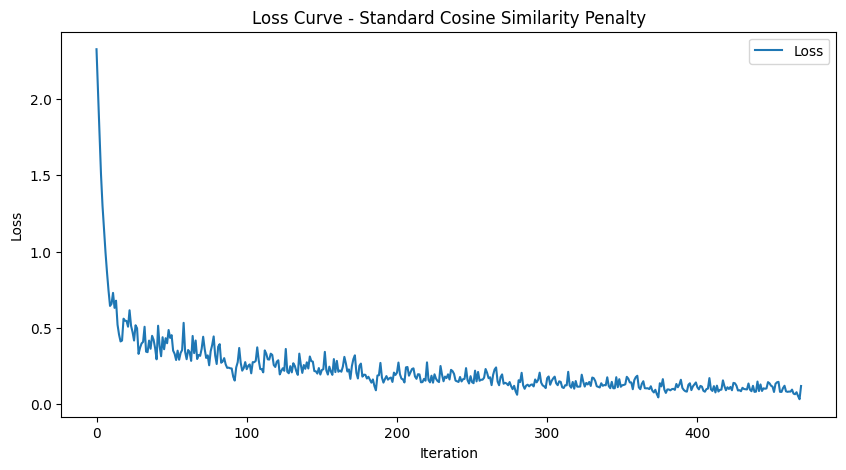

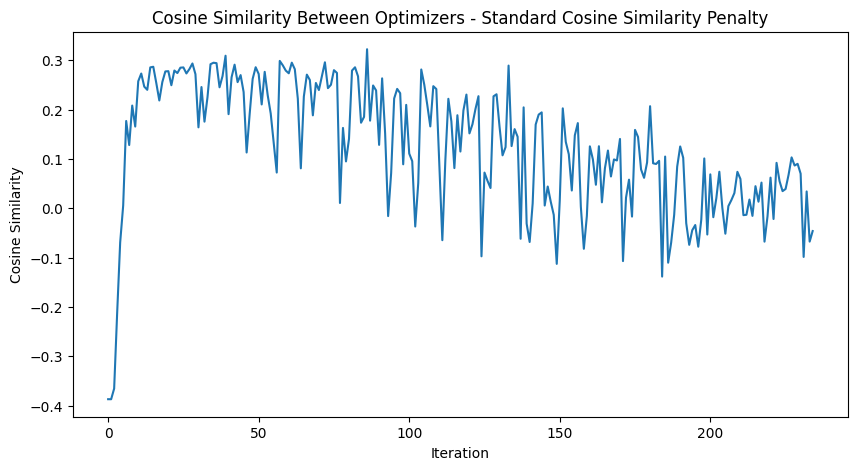

Standard Cosine Similarity Penalty Test Accuracy: 96.79%


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)

# Load test dataset
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=640, shuffle=False)

# Model Definition
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet().to(device)

# Utility Functions
def cosine_similarity(vec1, vec2):
    return torch.nn.functional.cosine_similarity(vec1, vec2, dim=0).item()

def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Standard Cosine Similarity Penalty Training Loop
def train_cosine_penalty(model, loader, epochs, lambda_penalty=0.1):
    print("\nStarting Standard Cosine Similarity Penalty Training...")
    criterion = nn.CrossEntropyLoss()
    model_cosine = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_cosine = optim.Adam(model_cosine.parameters(), lr=0.001)
    optimizer2_cosine = optim.Adam(model_cosine.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_cosine.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_cosine
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_cosine
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_cosine(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_cosine.parameters()])
            
            # Apply Cosine Similarity Penalty if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_cosine.parameters()])
                
                # Compute cosine similarity
                cos_sim = cosine_similarity(last_delta1, current_grads)
                cos_sim_list.append(cos_sim)
                
                # Apply fixed cosine similarity penalty
                penalty = lambda_penalty * last_delta1
                modified_grads = current_grads - penalty
                
                # Assign modified gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_cosine.parameters():
                        num_params = p.numel()
                        p.grad.copy_(modified_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_cosine.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nStandard Cosine Similarity Penalty Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_cosine, loss_list, cos_sim_list

# Training and Analysis
epochs = 5
lambda_penalty = 0.1  # Standard fixed penalty

# Train Standard Cosine Similarity Penalty method
model_cosine_penalty, loss_cosine_penalty, cos_sim_cosine_penalty = train_cosine_penalty(
    model, train_loader, epochs, lambda_penalty=lambda_penalty
)

# Visualization
def plot_losses(losses, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {method_name}')
    plt.legend()
    plt.show()

def plot_cosine_similarity(cos_sims, method_name):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title(f'Cosine Similarity Between Optimizers - {method_name}')
    plt.show()

# Plot Results for Standard Cosine Similarity Penalty
plot_losses(loss_cosine_penalty, "Standard Cosine Similarity Penalty")
plot_cosine_similarity(cos_sim_cosine_penalty, "Standard Cosine Similarity Penalty")

# Evaluate Model
accuracy_cosine_penalty = evaluate_model(model_cosine_penalty, test_loader)
print(f"Standard Cosine Similarity Penalty Test Accuracy: {accuracy_cosine_penalty:.2f}%")
